# Before you start

* Make sure to add shortcut to **Day8_Visual_Odometry** to your own drive
* Make sure to make a copy of this file in your own drive.
* You need to add codes where marked by **#TODO**

# Reference Materials
* [Multi View Geometry - Richard Hartley and Andrew Zisserman](https://users.cecs.anu.edu.au/~hartley/Papers/CVPR99-tutorial/tutorial.pdf)
* [Slides on Multi View Geometry](https://users.cecs.anu.edu.au/~hartley/Papers/CVPR99-tutorial/tutorial.pdf)
* [Introduction to Linear Algebra - Gilbert Strang](http://students.aiu.edu/submissions/profiles/resources/onlineBook/Y5B7M4_Introduction_to_Linear_Algebra-_Fourth_Edition.pdf)
* [Probabilistic Robotics - Sebastian Thrun](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)
* [ORB_SLAM3](https://github.com/UZ-SLAMLab/ORB_SLAM3)

# Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import tqdm
import plotly.express as px
import plotly.graph_objects as go

# Get Dataset

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
# Sanity Check
try:
  files = os.listdir('/gdrive/MyDrive/Day8_Visual_Odometry')
  print(f"Following files are available: {files}")
  print("You are good to go 🙂")
except:
  print('Dataset is not available 😟. Please check if there is a dir "Day8_Visual_Odometry" in your google drive.')

Following files are available: ['Visual_Odometry.ipynb', 'kitti.tar.xz', 'depths.txt', 'Tiny_NeRF_ANAIS.ipynb', 'NERF Original Paper.pdf', 'Visual-SLAM.pdf']
You are good to go 🙂


In [18]:
# Extract kitti dataset
!mkdir kitti
!tar -xJf /gdrive/MyDrive/Day8_Visual_Odometry/kitti.tar.xz -C kitti

mkdir: cannot create directory ‘kitti’: File exists
^C


In [19]:
# Get the list of image paths
frames = glob.glob("kitti/*.png")
frames.sort()

if len(frames)==0:
  print("There are no images 😟! You must have messed up the PATH!!!")
else:
  print(f"{len(frames)} frames available! You are good to go 🙂")

3001 frames available! You are good to go 🙂


# Utility Functions

In [23]:
def show_image(img):
  fig = plt.gcf()
  fig.set_size_inches(25,25)
  plt.imshow(img)

def estimate_relative_pose(extractor, frame_1, frame_2, cam_mat):
    kpts_1, descs_1 = extractor.detectAndCompute(frame_1, None)
    kpts_2, descs_2 = extractor.detectAndCompute(frame_2, None)

    matches = matcher.knnMatch(descs_1, descs_2, k=2)

    RATIO = 0.8
    good = []
    matched_kpts_1, matched_kpts_2 = [], []
    for (m1, m2) in matches: # for every descriptor, take closest two matches
        if m1.distance < RATIO * m2.distance: # best match has to be this much closer than second best
            good.append(m1)
            matched_kpts_1.append(kpts_1[m1.queryIdx].pt)
            matched_kpts_2.append(kpts_2[m2.trainIdx].pt)
    matched_kpts_1 = np.array(matched_kpts_1, dtype=np.float32)
    matched_kpts_2 = np.array(matched_kpts_2, dtype=np.float32)

    E, mask = cv2.findEssentialMat(
    matched_kpts_2, matched_kpts_1,
    cam_mat,
    method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, matched_kpts_2, matched_kpts_1, cam_mat)

    mask = (mask > 0)[..., 0]
    matched_kpts_1 = matched_kpts_1[mask]
    matched_kpts_2 = matched_kpts_2[mask]

    return R, t, matched_kpts_1, matched_kpts_2

def triangulate_3d_points(
    points_1, points_2, 
    intrinsic_matrix, 
    R1, t1, R2, t2
    ):
    R_t_old = np.zeros([3,4], dtype=np.float32)
    R_t_old[..., :-1] = R1
    R_t_old[..., -1] = t1
    cam_old = cam_mat @ R_t_old

    R_t_new = np.zeros([3,4], dtype=np.float32)
    R_t_new[..., :-1] = R2
    R_t_new[..., -1] = t2
    cam_new = cam_mat @ R_t_new

    triangulated_points_homogeneous = cv2.triangulatePoints(
        cam_old, cam_new, 
        points_1.T, points_2.T
    ).T

    triangulated_points = triangulated_points_homogeneous[..., :-1] / triangulated_points_homogeneous[..., [-1]]

    distances = np.linalg.norm(triangulated_points - t1, axis=1)
    triangulated_points = triangulated_points[distances < 10.0]

    camera_axis = np.array([0,0,-1]).T
    dots = (R_1 @ camera_axis).dot(triangulated_points.T)
    mask_from_dots = dots > 0.0

    return triangulated_points[mask_from_dots]

def get_ground_truth_scales(ground_truth_scales_file):
    scales = []
    last_t = None
    for line in ground_truth_scales_file:
        Rt = np.fromstring(line, sep=' ')
        Rt = Rt.reshape(3,4)
        R = Rt[:, :3]
        t = Rt[:, 3]
        if last_t is not None:
            scales.append(
                np.linalg.norm(t - last_t)
            )
        last_t = t
    return scales

# Step 1: Feature Extraction

In [24]:
# Define a feature extractor
feature_extractor = cv2.ORB_create(nfeatures=4096)

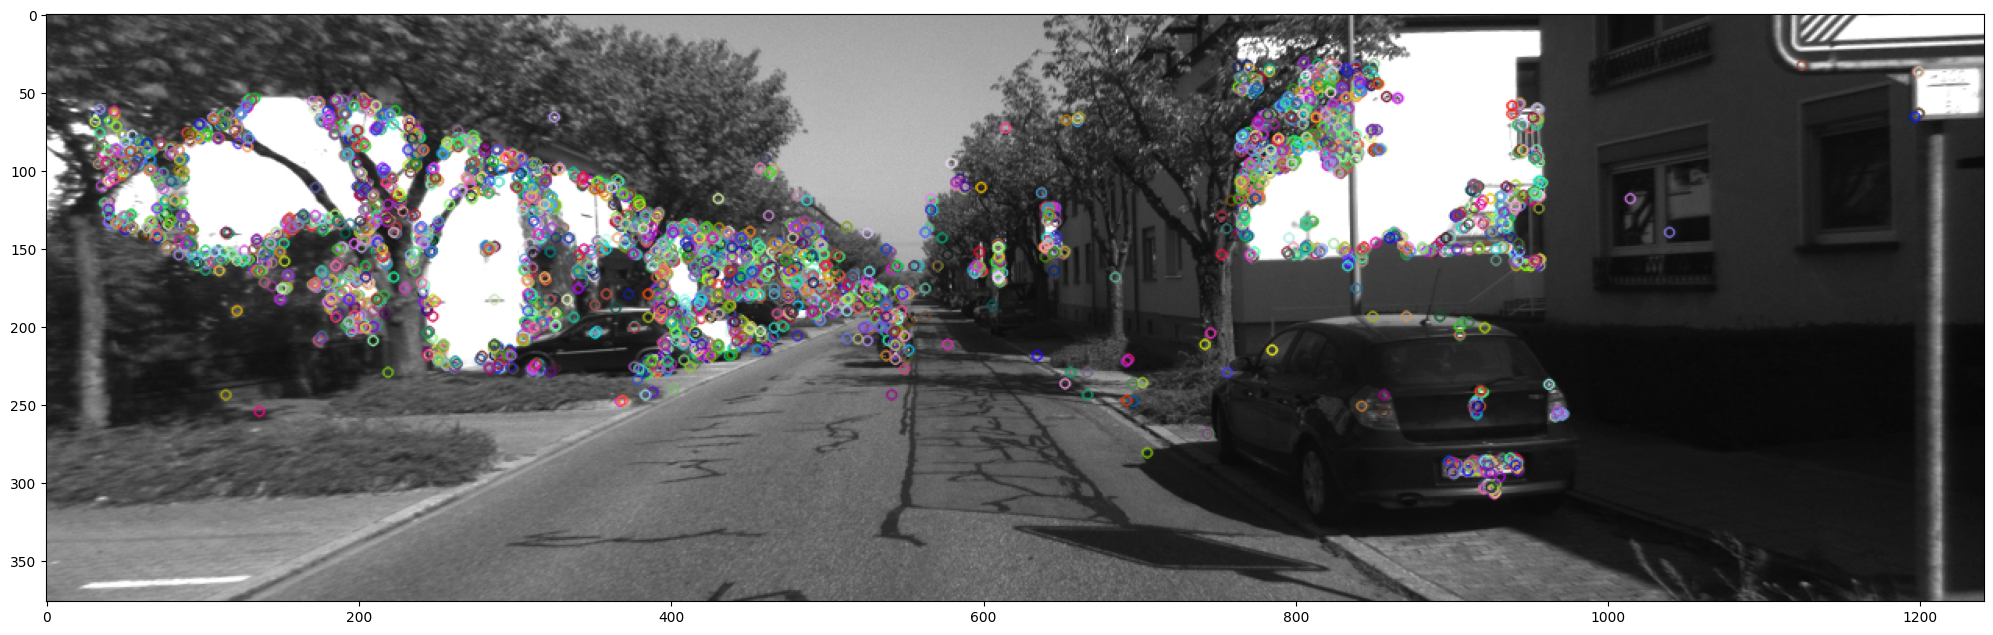

In [25]:
# Read first frame
frame_0 = cv2.imread(frames[0])

# Convert to Grayscale
frame_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2GRAY)

# Detect Keypoint in the frame with descriptors
keypoints_0, descriptors_0 = feature_extractor.detectAndCompute(frame_0,None)

# Draw Keypoints on the frame image
frame_0_with_keypoints = cv2.drawKeypoints(frame_0, keypoints_0, None, flags=0)

# Show the frame with keypoints
show_image(frame_0_with_keypoints)

# Step 2: Feature Matching

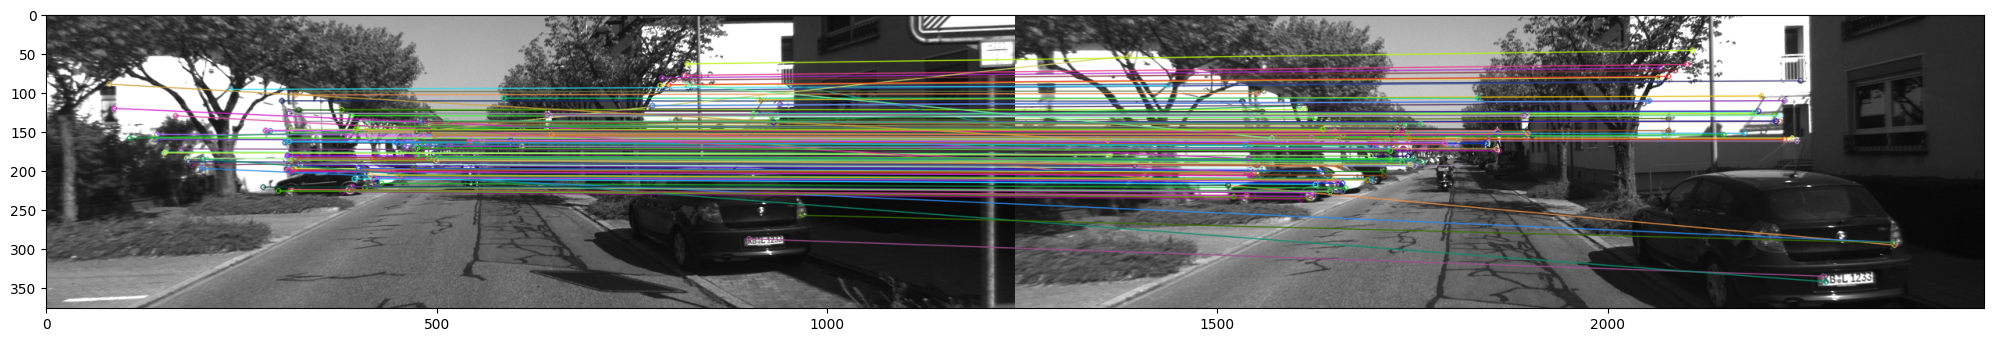

In [26]:
# with the name image.jpg  
# TODO: Read frames[3], similar to frames[0] above
frame_3 = cv2.imread(frames[3])

# Convert to Grayscale
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2GRAY)

# Detect Keypoint in the frame with descriptors
keypoints_3, descriptors_3 = feature_extractor.detectAndCompute(frame_3,None)

  
# Define Matcher
matcher = cv2.BFMatcher()

# Match keypoints in frame 1 and 3
matches = matcher.knnMatch(descriptors_0, descriptors_3, k=2)

# Apply Ratio Test
# TODO: Try with ratios: 0.6. 0.7, 0.8, 0.9, 1
RATIO = 0.8
good_matches = []
for (m1, m2) in matches: # for every descriptor, take closest two matches
    if m1.distance < RATIO * m2.distance: # best match has to be this much closer than second best
        good_matches.append(m1)

good_matches = sorted(good_matches, key = lambda x:x.distance)
   
# Plot the matches
image_with_matches = cv2.drawMatches(frame_0, keypoints_0, frame_3, keypoints_3, good_matches[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  
# Show matches
show_image(image_with_matches)

# Step 3: Visual Odometry

In [27]:
# Pre-defined camera intrinsics
cam_mat = np.array([
    [7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02],
    [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02],
    [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00],
])

# Load Ground truth scales
gts = get_ground_truth_scales(open("/gdrive/MyDrive/Day8_Visual_Odometry/depths.txt"))

# Define number of images to use
# TODO You can change the number of images, max=3000
# Single frame can take up to 3 sec
no_of_images = 50

# Read initial frame
frame_1 = cv2.imread(frames[0])

# Initial Pose is identity
R_id = np.eye(3)
t_id = np.array([0,0,0], dtype=np.float32)

R_1 = R_id.copy()
t_1 = t_id.copy()

# For the collect of Poses, Depths and 3D point clouds
ts = []
Rs = []
dts = []
point_cloud_map = []

print(f"Running Visual Odometry for {no_of_images} images...")
for image_file_name, ground_truth_scale in tqdm.tqdm(zip(frames[1:no_of_images], gts)):

    # Get the next frame
    frame_2 = cv2.imread(image_file_name) #TODO read image from "image_file_name"

    # TODO: Estimate relative pose between the two frames 
    # "estimate_relative_pose" function is available
    # Parameters:
    # 1. Feature Extractor
    # 2. First Frame
    # 3. Second Frame
    # 4. Camera intrinsic matrix
    dR, dt, points_1, points_2 = estimate_relative_pose(feature_extractor, frame_1, frame_2, cam_mat)

    dt = dt[...,0] * ground_truth_scale
    dts.append(dt)

    # Get absolute pose of this frame
    R_2 = dR.dot(R_1)
    t_2 = t_1 + R_1.dot(dt)

    # TODO: Triangulation
    # Function "triangulate_3d_points" is provided
    # Parameters: 
    # 1. Points from first image
    # 2. Points from second image
    # 3. Camera intrinsic matrix
    # 4. Identity rotation matrix
    # 5. Identity translation vector
    # 6. Relative rotation matrix
    # 7. Relative translation vector
    triangulated_points = triangulate_3d_points(
        points_1, points_2, 
        cam_mat,
        R_id, t_id,
        dR, dt,
    )


    triangulated_points = (R_2 @ triangulated_points.T).T
    triangulated_points += t_2

    # Collect the Poses and 3D point clouds
    point_cloud_map.append(triangulated_points)
    ts.append(t_2)
    Rs.append(R_2)

    # Prepare for next loop
    t_1 = t_2
    R_1 = R_2
    frame_1 = frame_2

ts = np.array(ts)
dts = np.array(dts)
point_cloud_map_concatted = np.concatenate(point_cloud_map)

print(f"{point_cloud_map_concatted.shape[0]} 3D points has been triangulated.")

Running Visual Odometry for 50 images...


49it [00:50,  1.02s/it]

13145 3D points has been triangulated.


# Step 4: Visualization

In [28]:
fig1 = px.scatter_3d(point_cloud_map_concatted, x=0, y=2, z=1)
fig1.update_traces(marker={'size': 1})

camera_axes = [R.T @ np.array([0,0,-1]).T for R in Rs] 
camera_axes = np.array(camera_axes)

fig2 = go.Figure(data=go.Cone(
    x=ts[..., 0],
    y=ts[..., 2],
    z=ts[..., 1],
    u=dts[..., 0],
    v=dts[..., 2],
    w=dts[..., 1],
    sizemode="absolute",
    sizeref=3,
    anchor="tail"))

go.Figure(data=fig1.data + fig2.data).show()